In [17]:
import numpy as np
import control
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Load matrices from CSV
A_d = pd.read_csv('data/statespace_models/A_discrete.csv', header=None).values
B_d = pd.read_csv('data/statespace_models/B_discrete.csv', header=None).values
C_d = pd.read_csv('data/statespace_models/C_discrete.csv', header=None).values
D_d = pd.read_csv('data/statespace_models/D_discrete.csv', header=None).values

# Load dt from text file
with open('data/statespace_models/dt_discrete.txt', 'r') as f:
    dt = float(f.read().strip())

# Create the discrete system
sys_d = control.ss(A_d, B_d, C_d, D_d, dt)

In [19]:
# Load observer gains
L_c = pd.read_csv('data/gain_matrices/L_Continuous.csv', header=None).values
L_d = pd.read_csv('data/gain_matrices/L_Discrete.csv', header=None).values

# Load controller gains
K_c = pd.read_csv('data/gain_matrices/K_Continuous.csv', header=None).values
K_d = pd.read_csv('data/gain_matrices/K_Discrete.csv', header=None).values

In [20]:
# Load ekf Q and R
Qn = pd.read_csv('data/nonlinear_matrices/Qn.csv', header=None).values
Rn = pd.read_csv('data/nonlinear_matrices/Rn.csv', header=None).values

# Nonlinear Controller Simulation

In [21]:
# Initial State
x0 = np.array([0.0, 0.0, 0.0, 0.0])

In [22]:
dt = sys_d.dt
T_d = np.arange(0, 10, dt)
t_eval_d = T_d

## Extended Kalman Filter

<p align="center">
  <img src="Diagrams/EKF/EKF.png" alt="Alt text" width="600" height="500"/>
</p>


In [23]:
from utils import ekf_simulation_nonlinear_discrete
# Run simulation
measurement_noise_std = np.array([0.01, 0.01, 0.1, 0.1])
disturbance_std = np.array([0.0, 0.01, 0.01, 0.01])
t_impulse = 3
impulse_magnitude = np.array([0.00, 0.00, 0.1, 0.1])
P0 = np.diag([
    1e-3,  # position variance (m^2)
    1e-2,  # velocity variance (m/s)^2
    1e-2,  # angle variance (rad^2)
    1e-1   # angular velocity variance (rad/s)^2
])

T_ekf_d, x_true_ekf_d, x_hat_ekf_d, tau_ekf_d = ekf_simulation_nonlinear_discrete(
    x0, P0, K_d,t_eval_d, Qn, Rn,
    measurement_noise_std=None,
    disturbance_std=None,
    t_impulse=None,
    impulse_magnitude=None,
    low_pass_enabled=True)

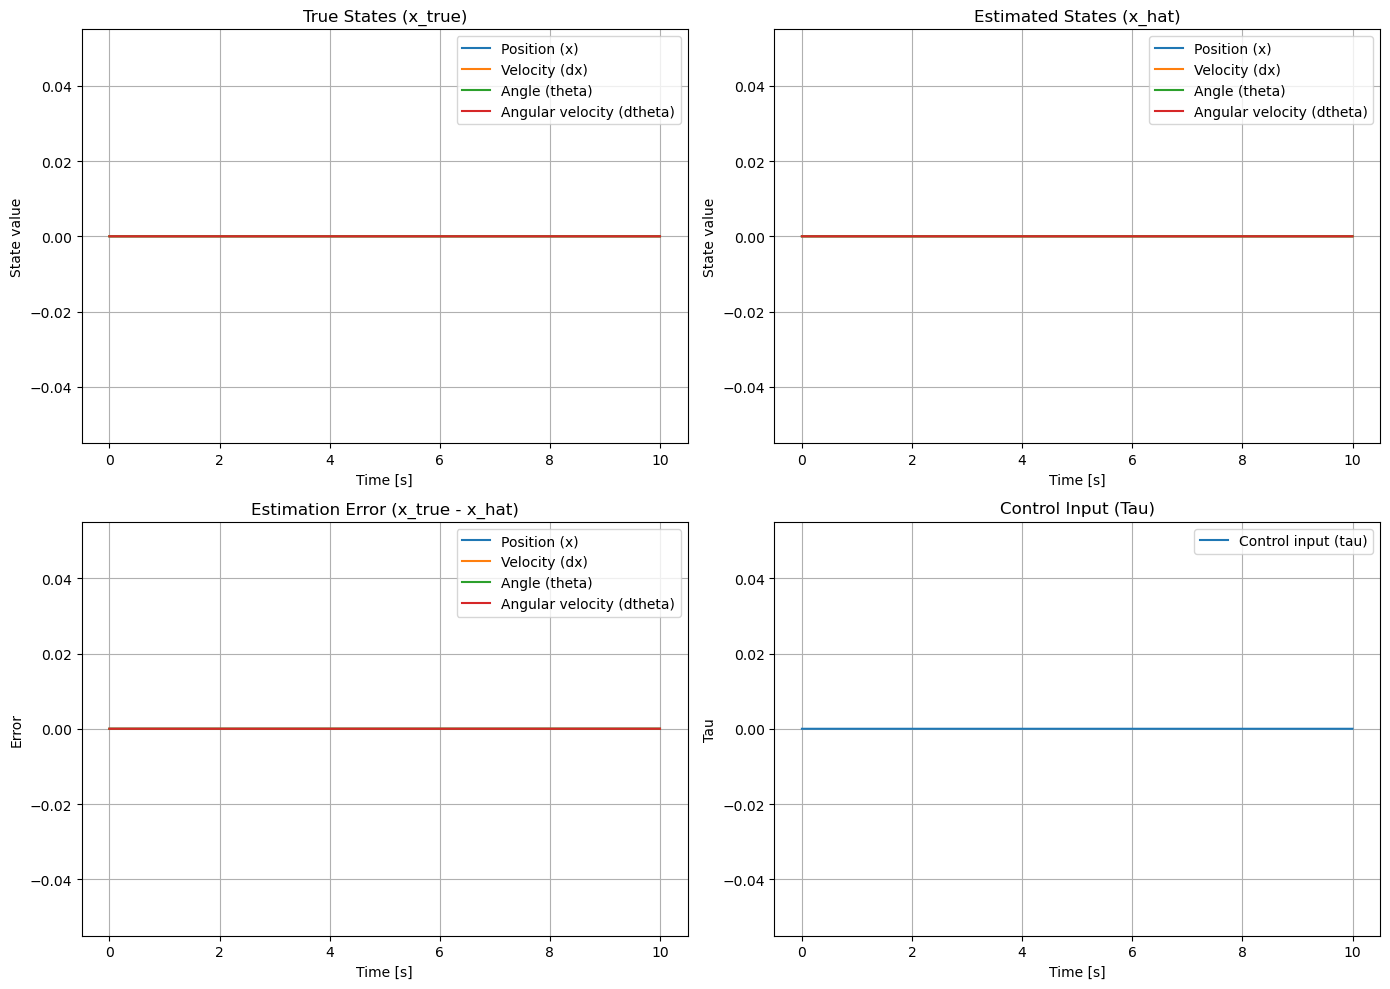

In [24]:
import matplotlib.pyplot as plt

state_labels = ['Position (x)', 'Velocity (dx)', 'Angle (theta)', 'Angular velocity (dtheta)']

plt.figure(figsize=(14, 10))

# True states
plt.subplot(2, 2, 1)
for i in range(4):
    plt.plot(T_ekf_d, x_true_ekf_d[i], label=state_labels[i])
plt.title('True States (x_true)')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Estimated states
plt.subplot(2, 2, 2)
for i in range(4):
    plt.plot(T_ekf_d, x_hat_ekf_d[i], label=state_labels[i])
plt.title('Estimated States (x_hat)')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Estimation error
plt.subplot(2, 2, 3)
for i in range(4):
    plt.plot(T_ekf_d, x_true_ekf_d[i] - x_hat_ekf_d[i], label=state_labels[i])
plt.title('Estimation Error (x_true - x_hat)')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Control input
plt.subplot(2, 2, 4)
plt.plot(T_ekf_d, tau_ekf_d, label='Control input (tau)')
plt.title('Control Input (Tau)')
plt.xlabel('Time [s]')
plt.ylabel('Tau')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
